# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Загрузка данных. 

In [3]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'first_day_exposition'}>],
       [<AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>],
       [<AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>],
       [<AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>],
       [<AxesSubplot:title={'center':'ponds_nearest'}>,
        <AxesSubplot:title={'center':'days_exposition'

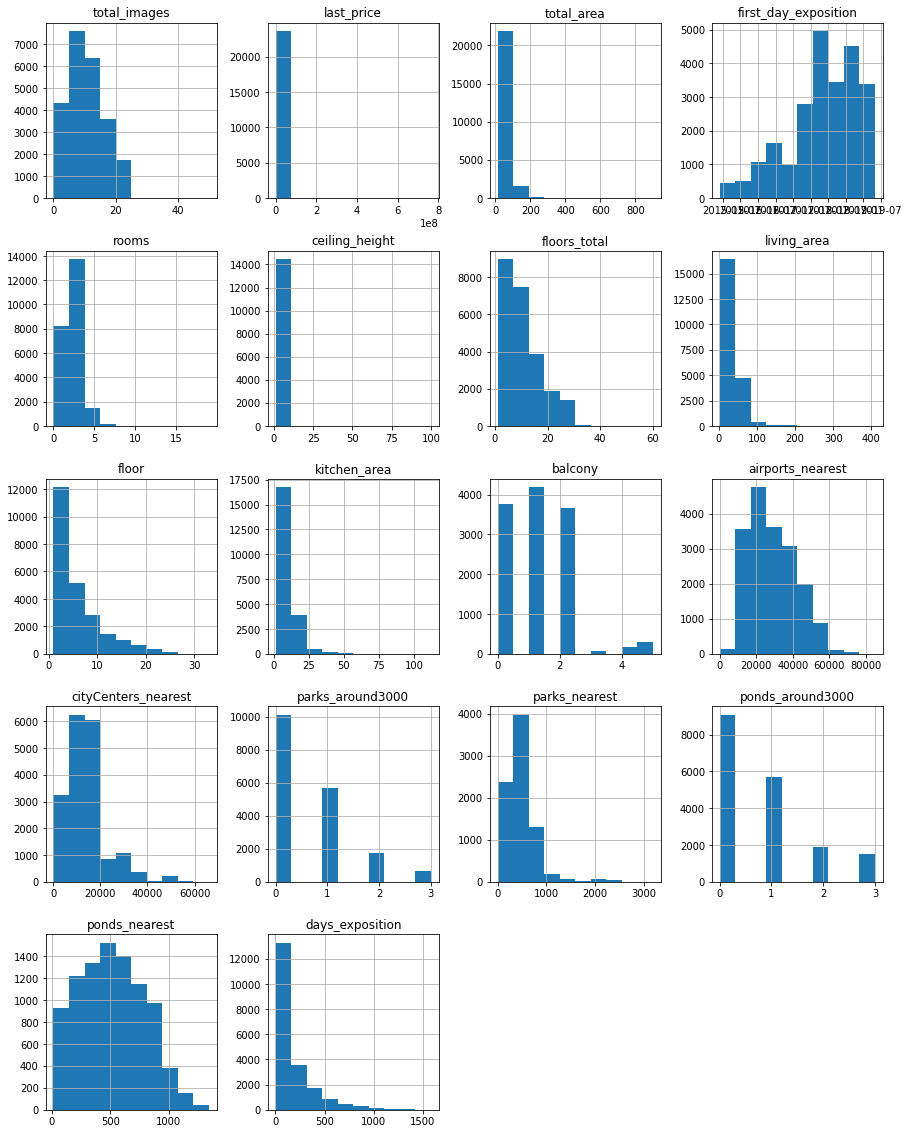

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.first_day_exposition = pd.to_datetime(data.first_day_exposition,format='%Y-%m-%dT%H:%M:%S')#распаковал данные
data.info()#изучил данные
data.hist(figsize=(15, 20),bins=10)#постороил гистограммы

Датафрейм представляют из себя данные по проданным квартирам и некоторый набор дополнительной информации о квартирах.Изучив изначальные данные мы видим, что у нас 3 категориальные переменные(is_apartment, studio, open_plan) и все остальные - количественные. Графики показывают наличие пропусков.

# Предобработка данных

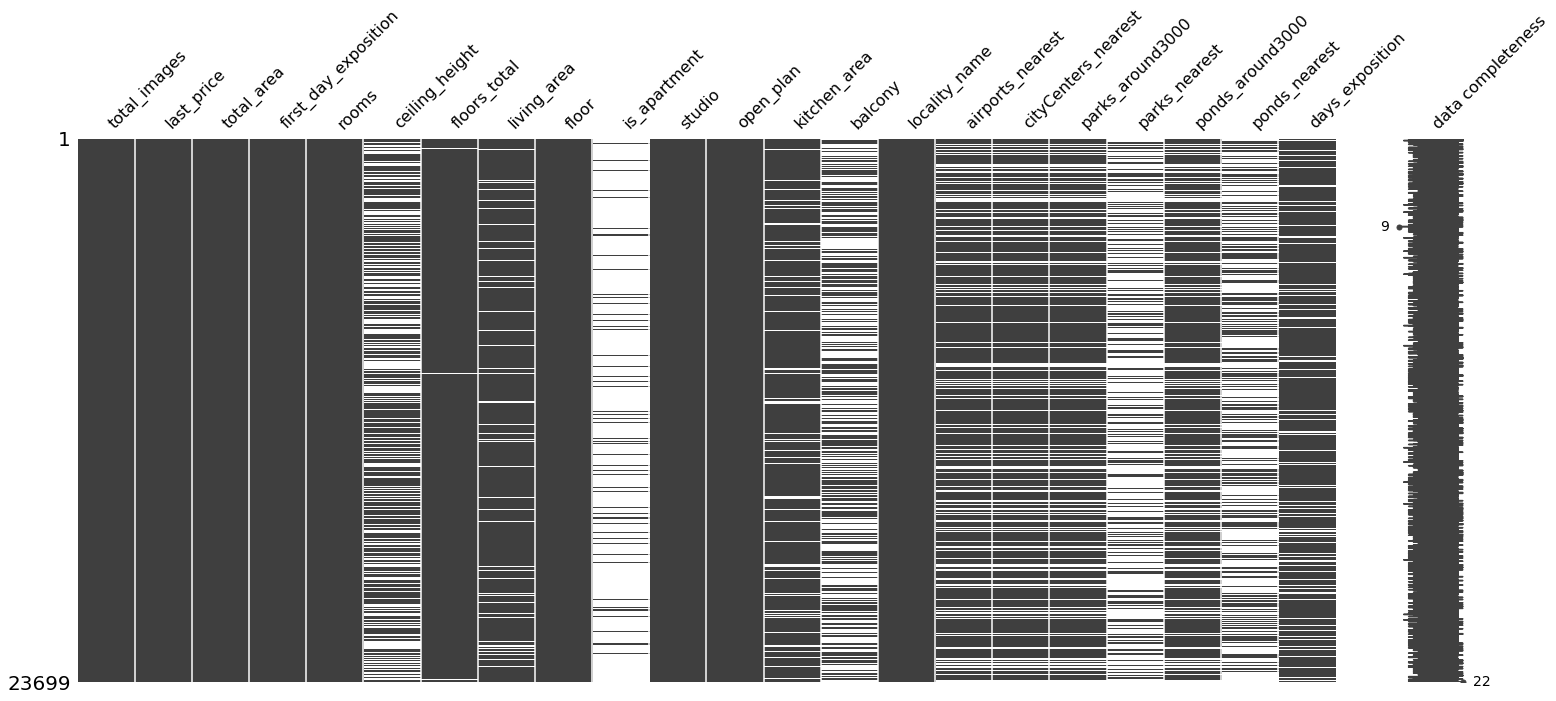

In [5]:
msno.matrix(data, labels=True)
plt.show()# вывел график отображающий пропуски в каждом из столбцов

In [6]:
data.living_area=data.living_area.dropna()
    
for column in data.columns:
       print(column, data[column].isna().sum())#нашел пропуски в каждом из столбцов

for column in data.columns:
    if column in ['balcony', 'parks_nearest', 'airports_nearest', 'parks_around3000', 'ponds_nearest','ponds_around3000']:
        data[column] = data[column].fillna('0')#заполнил очевидные пропуски
        
data.is_apartment = data.is_apartment.where(data.studio == False).fillna('True')#нам дано 2 типа жилья is_apartment и studio, поэтому если это не студия то это апартаменты.
data.is_apartment = data.is_apartment.astype(bool) # изменил тип данных столбца для уменьшения требуемой памяти датафрейма

print(len(data.locality_name.unique()))# 365 уникальных записей до удаления неявных дубликатов
data.locality_name = data.locality_name.str.lower().str.replace('посёлок ', '').str.replace('городской ', '').str.replace('деревня ', '').str.replace('садовое товарищество ', '').str.replace('поселок ', '').str.replace('городского типа ', '').str.replace('село ', '')
data.dropna(subset=['living_area'], inplace=True)#удалил неявные дубликаты
print(len(data.locality_name.unique()))# 294 после удаления неявных дубликатов



total_images 0
last_price 0
total_area 0
first_day_exposition 0
rooms 0
ceiling_height 9195
floors_total 86
living_area 1903
floor 0
is_apartment 20924
studio 0
open_plan 0
kitchen_area 2278
balcony 11519
locality_name 49
airports_nearest 5542
cityCenters_nearest 5519
parks_around3000 5518
parks_nearest 15620
ponds_around3000 5518
ponds_nearest 14589
days_exposition 3181
365
294


Во время обработки данных выяснилось, что в них содержится значительное количество пропусков. Некоторые из этих данных, вероятно, были утеряны в процессе передачи, а другие отсутствуют, поскольку соответствующей информации просто нет для конкретной квартиры. Мной было принято решение заменить пропуски в следующих столбцах: balcony, parks_nearest, airports_nearest, parks_around3000, ponds_nearest, ponds_around3000 на 0, так как отсутствие данных в этих столбцах, вероятно, означает, что, например, балконы (в записях, где значение столбца balcony=Nan), скорее всего, отсутствуют в самой квартире. Также, при изучении данных, я заметил, что в категориальной переменной is_apartment много пропусков. Учитывая, что в представленных данных всего 2 типа жилья: studio и is_apartment, я пришел к выводу, что если квартира не является студией, то это - аппартаменты. Затем я проверил названия городов в объявлениях на наличие неявных дубликатов. Их оказалось достаточно много (365), и для более точного исследования я избавился от всех неявных дубликатов (после удаления неявных дубликатов осталось всего 294 уникальных значения).

# Добавление в таблицу новых данных

In [7]:
def floor_group(row): # функция для разделения этажей на группы
    if row['floor'] == 1:
        return 'первый'
    elif row['floors_total'] - row['floor'] == 0:
        return 'последний'
    return 'другой'

#Создание новых столбцов
data['price_per_m'] = round(data.last_price / data.total_area, 2)
data['day'] = data.first_day_exposition.dt.strftime('%A')
data['month'] = data.first_day_exposition.dt.strftime('%B')
data['Year'] = data.first_day_exposition.dt.strftime('%Y')
data['cityCenters_nearest_km'] = round(data.cityCenters_nearest / 1000, 2)
data['floor_type'] = data.apply(floor_group, axis=1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m,day,month,Year,cityCenters_nearest_km,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,True,...,482.0,2.0,755.0,NaN,120370.37,Thursday,March,2019,16.03,другой
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,True,...,0,0.0,0,81.0,82920.79,Tuesday,December,2018,18.60,первый
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,True,...,90.0,2.0,574.0,558.0,92785.71,Thursday,August,2015,13.93,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,True,...,112.0,1.0,48.0,121.0,100000.00,Tuesday,June,2018,8.10,другой
5,10,2890000.0,30.4,2018-09-10,1,NaN,12.0,14.4,5,True,...,0,0,0,55.0,95065.79,Monday,September,2018,NaN,другой


# Иследовательский анализ данных

In [8]:
data.loc[data['cityCenters_nearest'] > 30000, 'cityCenters_nearest'] /= 10
data.loc[data['cityCenters_nearest_km'] > 30000, 'cityCenters_nearest_km'] /= 10#невозможно далекие для городов представленных в данных значения для удаленности от центра
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] /= 10# исправил сликом большие значения в ceiling_height
data = data[data['floors_total'] <= 37] #cреди представленных городов самое высокое жилое здание имеет 37 этажей
data = data.reset_index(drop=True)

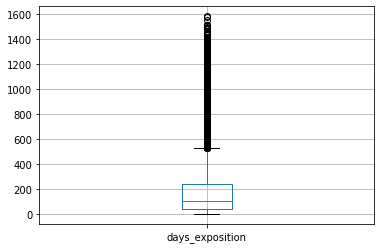

In [25]:
data.days_exposition.hist()
data.days_exposition.mean()#185
data.days_exposition.median()#101

data.boxplot(column='days_exposition')# основываясь на этот график можно сказать что быстрая продажа это продажа быстрее 100 дней, а долгая это продажа дольше 500 дней
correlation_matrix = data.select_dtypes(include=['float64', 'int64']).corr()
print(correlation_matrix)# основываясь на данных кореляции Пирсона больше всего цена зависит от общей площади, жил.площади и размеров кухни

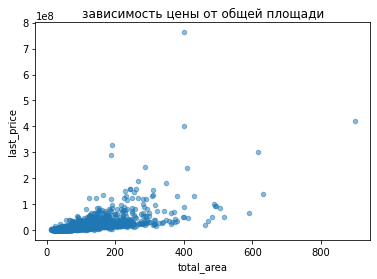

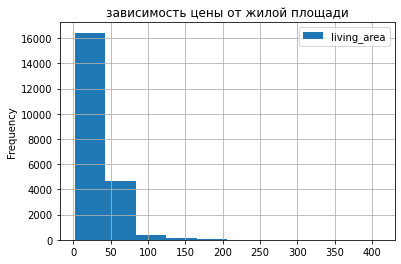

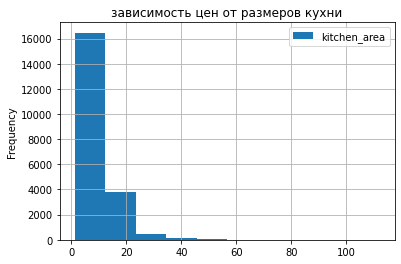

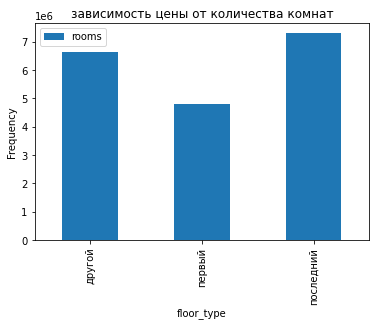

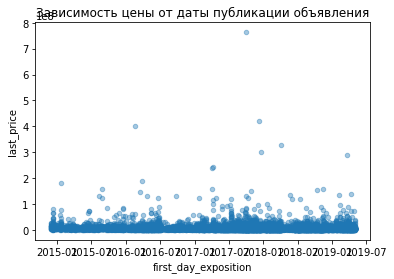

In [29]:
# Создание графиков для визуализации зависимостей
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.5, title='зависимость цены от общей площади')
plt.show()

data.plot(x='last_price', y='living_area', grid=True, kind='hist',title='зависимость цены от жилой площади')

data.plot(x='last_price', y='kitchen_area', grid=True, kind='hist',title='зависимость цен от размеров кухни')

data.plot(x='last_price', y='rooms', grid=True, kind='hist',title='зависимость цены от количества комнат')

grouped_data = data.groupby('floor_type')['last_price'].mean()
grouped_data.plot.bar()
plt.show()

data.plot(x='first_day_exposition', y='last_price',kind='scatter', alpha=0.4,title='Зависимость цены от даты публикации объявления')
plt.show()

                   ads  price_per_m
locality_name                      
санкт-петербург  14533   104500.000
мурино             524    86842.470
кудрово            422    96052.630
шушары             403    77352.940
всеволожск         371    65789.470
пушкин             345   100000.000
колпино            328    74723.745
парголово          301    91642.860
гатчина            292    67746.285
петергоф           197    81993.570


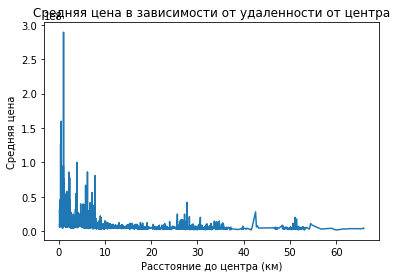

In [9]:
top_ten=pd.pivot_table(data, 
                                index='locality_name', 
                                values=['price_per_m', 'last_price'], 
                                aggfunc={'last_price': 'count', 'price_per_m': 'median'}).sort_values(by='last_price', ascending=False).head(10)
top_ten.columns=['ads','price_per_m'] # нашел топ 10 городов с самым большим количеством обьявлений и посчитал среднюю цену за кв.м в этих городах
print(top_ten)
spb=data[data['locality_name'] == 'санкт-петербург']# сделал срез по Петербургу
mean_price_by_distance = pd.pivot_table(spb,
    index='cityCenters_nearest_km',
    values='last_price',
    aggfunc='median'
)
mean_price_by_distance = data.groupby('cityCenters_nearest_km')['last_price'].mean()
mean_price_by_distance.plot(kind='line', title='Средняя цена в зависимости от удаленности от центра')
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Средняя цена')
plt.show() #вывел график зависимости цены от удаленности от центра

# Общий вывод

В ходе исследования был проведен анализ различных факторов, оказывающих влияние на конечную стоимость квартиры. Проанализировав данные, я выявил три основных фактора, сильно влияющих на цену недвижимости: общая площадь, жилая площадь и площадь кухни. Эти данные отображают, то что интересует покупателей больше всего при покупке недвижимости.

Осуществив отбор "хороших данных" без критически важных пропусков и дубликатов, я смог более точно оценить влияние различных параметров на стоимость недвижимости.

Изучая время продажи квартир, я выявил, что быстрая продажа обычно занимает до 100 дней, в то время как долгая – более 500 дней. Эти временные рамки могут служить важным показателем для продавцов и покупателей, помогая им лучше понимать рынок.

Создание сводной таблицы для анализа средней цены за квадратный метр в различных городах помогает более детально понять рынок недвижимости в различных городах Росии, а создавние сводной таблицы и графика для визуализации зависимости растояния от продоваемой недвижимости до центра города, показало , что цена квартиры и растояние до центра города имеют сильную зависимость.

Обобщая полученные результаты, можно заключить, что факторы, такие как площадь квартиры и расстояние от центра города, существенно влияют на формирование стоимости жилья. Однако, дополнительные аспекты исследования такие как: ближайшие станции метро, количество школ/больниц и тд, могут дать более полное представление о рынке недвижимости.
P.s
Я знаю, что не написал промежуточные выводы, но я просто не вижу полей в которые мог бы вписать эти выводы.